In [ ]:
%%time
import os
import pandas as pd
import networkx as nx
import pyarrow.parquet as pq

base_dir = 'D:Users/Paschalis/phd/data/'  # base directory where the different language versions are saved

language_codes = ['en', 'es', 'it', 'el', 'nl', 'pl', 'eu', 'hi', 'de']  # adjust if you want to add more or remove existing ones

metrics = []

def calculate_graph_metrics(df, language_code):
    """
    Calculate various metrics for a graph stored as a Pandas DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing 'Source' and 'Target' columns.
        language_code (str): The language code of the graph.

    Returns:
        dict: A dictionary of calculated metrics for the graph.
    """
    # Create a directed graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='Source', target='Target', create_using=nx.DiGraph)

    # Calculate basic metrics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    density = nx.density(G)

    # Store the metrics
    metrics_dict = {
        'language_code': language_code,
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'average_in_degree': sum(in_degrees.values()) / num_nodes if num_nodes > 0 else 0,
        'average_out_degree': sum(out_degrees.values()) / num_nodes if num_nodes > 0 else 0,
        'max_in_degree': max(in_degrees.values(), default=0),
        'max_out_degree': max(out_degrees.values(), default=0),
        'in_degree_distribution': in_degrees,  # Store as dictionary
        'out_degree_distribution': out_degrees,  # Store as dictionary
        'density': density
    }
    return metrics_dict

# Loop through each language folder and process its graph
for language in language_codes:
    file_path = os.path.join(base_dir, f"{language}/graph/{language}_wiki_graph.parquet")
    df = pd.read_parquet(file_path, columns=['Source', 'Target'])
    print(f"Processing {language} graph with {len(df)} edges...")
    # Calculate metrics for the graph
    language_metrics = calculate_graph_metrics(df, language)
    metrics.append(language_metrics)

# Convert the metrics into a DataFrame for comparison
metrics_df = pd.DataFrame(metrics)

Processing en graph with 140233009 edges...
Processing es graph with 33344361 edges...
Processing it graph with 42906457 edges...
Processing el graph with 3794715 edges...
Processing nl graph with 27553227 edges...
Processing pl graph with 30138045 edges...
Processing eu graph with 4440116 edges...
Processing hi graph with 1126513 edges...
Processing de graph with 76792004 edges...
CPU times: total: 25min 42s
Wall time: 25min 38s


In [4]:
metrics_df = metrics_df.sort_values('num_nodes', ascending=False)
metrics_df.to_csv("D:Users/Paschalis/phd/data/graph_metrics_lang.csv",
                 index=False)

In [1]:
import pandas as pd
metrics_df = pd.read_csv("D:Users/Paschalis/phd/data/graph_metrics_lang.csv")

In [2]:
metrics_df

,language_code,num_nodes,num_edges,average_in_degree,average_out_degree,max_in_degree,max_out_degree,in_degree_distribution,out_degree_distribution,density
0,en,6720886,140233009,20.865256,20.865256,188311,4588,"{0: 1169, 45580: 89, 352716: 204, 854409: 27, ...","{0: 221, 45580: 23, 352716: 86, 854409: 18, 28...",0.000003
1,es,3355884,33344361,9.936089,9.936089,183293,3652,"{0: 1680, 3283175: 10, 159275: 100, 564: 37622...","{0: 359, 3283175: 1, 159275: 124, 564: 431, 19...",0.000003
2,de,2933122,76792004,26.180978,26.180978,204835,10676,"{'alan smithee': 60, 'pseudonym': 8356, 'regis...","{'alan smithee': 38, 'pseudonym': 187, 'regiss...",0.000009
3,nl,2168204,27553227,12.707857,12.707857,163511,12760,"{'albert speer': 164, 'mannheim': 777, '19 maa...","{'albert speer': 99, 'mannheim': 102, '19 maar...",0.000006
4,it,1817866,42906457,23.602651,23.602651,153415,5179,"{'armonium': 382, 'lingua francese': 15697, 'o...","{'armonium': 100, 'lingua francese': 354, 'org...",0.000013
5,pl,1622506,30137502,18.574663,18.574663,138618,3798,"{'awk': 29, 'język programowania': 890, 'plik ...","{'awk': 25, 'język programowania': 73, 'plik d...",0.000011
6,eu,435231,4440116,10.201746,10.201746,65339,1573,"{0: 563, 107294: 8, 2212: 1654, 20504: 103, 24...","{0: 197, 107294: 9, 2212: 75, 20504: 59, 2415:...",0.000023
7,el,235927,3794715,16.084276,16.084276,16312,1464,"{0: 1, 40408: 13246, 502: 10469, 9337: 60, 8: ...","{0: 10, 40408: 745, 502: 426, 9337: 226, 8: 23...",0.000068
8,hi,159255,1126513,7.073643,7.073643,42123,4018,"{'हम होंगे कामयाब': 3, 'गिरिजा कुमार माथुर': 1...","{'हम होंगे कामयाब': 2, 'गिरिजा कुमार माथुर': 4...",0.000044


# Plotting the in-degree and the out-degree distribution for each WP graph in each language version

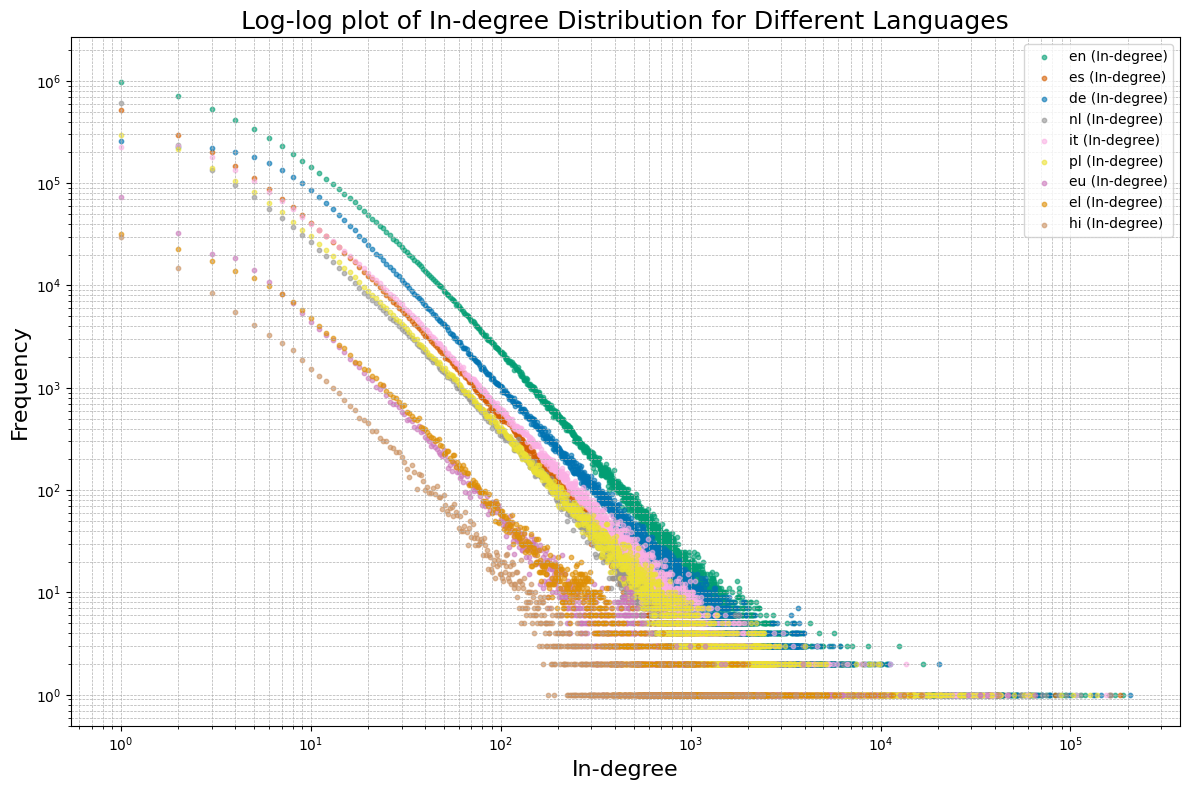

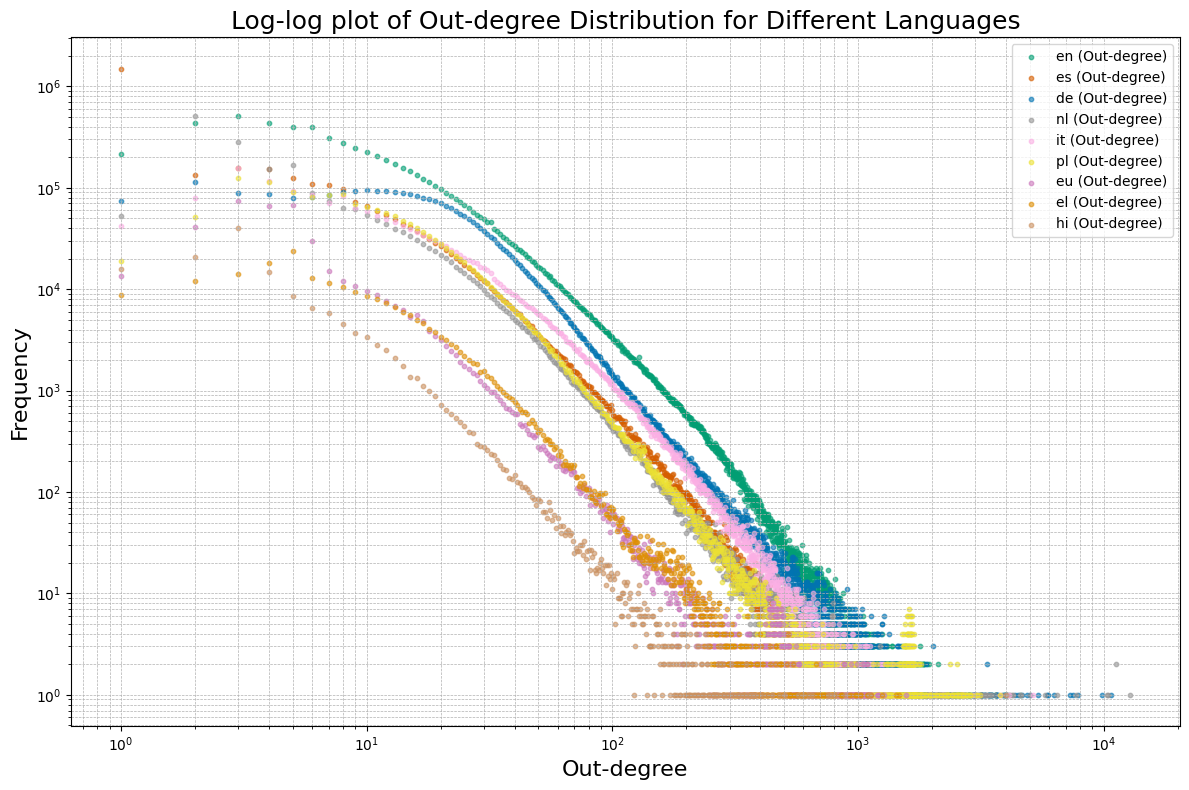

In [5]:
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Sort languages to ensure consistent color mapping
languages = sorted(set(metrics_df["language_code"]))
colorblind_palette = sns.color_palette("colorblind", len(languages))

# Assign a fixed color to each language
language_colors = {lang: color for lang, color in zip(languages, colorblind_palette)}

language_versions_processed = dict()
for index, row in metrics_df.iterrows():
    language = row["language_code"]

    # Parse degree distributions if stored as strings
    in_degrees = row["in_degree_distribution"]
    out_degrees = row["out_degree_distribution"]

    if isinstance(in_degrees, str):
        in_degrees = ast.literal_eval(in_degrees)  # Safely evaluate string to dictionary
    if isinstance(out_degrees, str):
        out_degrees = ast.literal_eval(out_degrees)

    # Convert to list for plotting
    in_degrees = list(in_degrees.values())
    out_degrees = list(out_degrees.values())

    # Store in a dictionary for plotting
    language_versions_processed[language] = {
        "in_degrees": in_degrees,
        "out_degrees": out_degrees,
    }

# Plot in-degree distribution
plt.figure(figsize=(12, 8))
for language, data in language_versions_processed.items():
    in_degree_counts = Counter(data["in_degrees"])
    x_in, y_in = zip(*in_degree_counts.items())
    plt.scatter(
        x_in, y_in, label=f"{language} (In-degree)", alpha=0.6, s=10, color=language_colors[language]
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("In-degree", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Log-log plot of In-degree Distribution for Different Languages", fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
# plt.savefig('../results/in_deg_dist_multiling.png', dpi=500)
plt.show()

# Plot out-degree distribution
plt.figure(figsize=(12, 8))
for language, data in language_versions_processed.items():
    out_degree_counts = Counter(data["out_degrees"])
    x_out, y_out = zip(*out_degree_counts.items())
    plt.scatter(
        x_out, y_out, label=f"{language} (Out-degree)", alpha=0.6, s=10, color=language_colors[language]
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Out-degree", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Log-log plot of Out-degree Distribution for Different Languages", fontsize=18)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
# plt.savefig('../results/out_deg_dist_multiling.png', dpi=500)
plt.show()